### web crawling
- 1. requests: json: 동적페이지(URL 변경 없이 데이터를 수정 및 추가)
    - 동적: 데이터를 가져올때 URL 변화 o
- 2. requests: html: 정적페이지(URL 변경으로 데이터를 수정 및 추가)
    - 정적: 데이터를 가져올때 URL 변화 x
- 3. selenium: web browser: 1, 2번 방법을 사용하지 못할때 사용 

### 1. 네이버 주식 데이터 크롤링
- 코스피 데이터 수집
- 코스닥 데이터 수집
- USD 환율 데이터 수집
- 그래프, 상관계수 확인

### 크롤링 절차
- 1. 웹 서비스 분석: URL 확인 -> Requests  url 가져오기
    - 사용: 
        - Request Url을 가저옴
    - tip: 웹 페이지 보다 모바일 페이지가 기능이 적어 활요하기 수월
    - URL 확인및 정보얻기: 개발자 모드 - network 탭 - XHR 탭( 데이터 송수신 정보 전부 확인 가능 )
        - 동작 URL 정보 확인가능: JSON or HTML, USER_AGET
    - User-Agent: 내 PC 환경 정보
- 2. request, response: json 데이터(문자열)를 얻기
    - 사용:
        - response = requests.get(url)
- 3. json 데이터(문자열) -> dict(파싱) -> 데이터 프레임
    - 사용:
        - datas = reponse.json()["result"]["siseList"] # type: dict, []안의 데이터 확인
        - result = pd.DataFrame(datas)
- ? 데이터 얻는 과정 에러
    - ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [70]:
# import requests

In [5]:
# 1. 웹서비스 분석
    # 네이버 증권 URL
code, page_size, page = "KOSPI", 20, 1
url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code={}&pageSize={}&page={}\
".format(code, page_size, page)

print(url)

https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=20&page=1


In [6]:
# 2. request, response: JSON(str)
response = requests.get(url)
response

<Response [200]>

In [7]:
# 3. JSON(str) -> JSON(dict) -> DataFrame
type(response.text)   # str
type(response.json()) # dict

datas = response.json()["result"]["siseList"]
kospi_df = pd.DataFrame(datas)
kospi_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
18,KOSPI,20200924,2272.70,-60.54,-2.59,2295.62,2309.74,2268.88
19,KOSPI,20200923,2333.24,0.65,0.03,2352.56,2354.46,2287.44


In [8]:
# url 만드는 부분 함수
def get_stock_data(code, page_size=20, page=1):
    url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code={}&pageSize={}&page={}\
".format(code, page_size, page)
    response = requests.get(url)
    datas = response.json()["result"]["siseList"]
    return pd.DataFrame(datas)

In [9]:
kosdaq_df = get_stock_data("KOSDAQ",100)
kosdaq_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
98,KOSDAQ,20200603,737.66,-5.92,-0.80,749.49,750.14,734.63
99,KOSDAQ,20200602,743.58,7.86,1.07,737.67,743.70,735.06


In [10]:
kospi_df = get_stock_data("KOSPI",100)
kospi_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
98,KOSPI,20200603,2147.00,59.81,2.87,2108.55,2156.55,2107.69
99,KOSPI,20200602,2087.19,22.11,1.07,2061.45,2089.43,2059.14


### USD 수집

In [11]:
# 1. 웹페이지 분석: URL
code, page_size, page = "FX_USDKRW", 100, 1

url = "https://m.stock.naver.com/api/json/marketindex/marketIndexDay.nhn?\
marketIndexCd={}&pageSize={}&page={}".format(code, page_size, page)

print(url)

https://m.stock.naver.com/api/json/marketindex/marketIndexDay.nhn?marketIndexCd=FX_USDKRW&pageSize=100&page=1


In [12]:
# 2. 데이터 얻기: request, response: JSON(str)
response = requests.get(url)
response # 데이터를 받아는 오나
response.text # 로그인이 필요하다는 메시지였음

'{"result":{"errorMessage":"로그인이 필요한 서비스 입니다.\\n로그인 하시겠습니까?","errorCode":"authenticationFail"},"resultCode":"error"}'

In [13]:
# 해결을 위해 / 보통 로그인 정보는 쿠키에 넣고있음
    # 쿠키 데이터 추가해서 요청
params = {
    "cookie": "cookie: NNB=E6IWAM2B6WGF6; NRTK=ag#all_gr#1_ma#-2_si#0_en#0_sp#0; nx_ssl=2; page_uid=UH413dprvhGss7CYsC0ssssstah-276006; MM_NEW=1; NFS=2; MM_NOW_COACH=1; nid_inf=806554524; NID_AUT=o2dDPZgM5DQzksuYv2fHI9Nv+xXjJVQ70rIiXeNHJ6k2fi9t0725pMb5l3a2+aSn; NID_SES=AAABrlICVGnd9FLha5M2tAxZxJGiM7FiRK3NMX3dKxlDXO9LimReWQPrSUEl20/BaFQtdhwoq54MFctOXMjT3hi4oLU8jq19bl9XKZlGaPLbUsxyMlptOZfdPeyjdJFpq2fYuFbJGfVjRoqMrdrnVcKhKB3It9wQ2pplDoJ3m7xZqyXAJuxwlaSpfySiP2UEoqBXxFGihTuj0P4AvGK64S5/eciMlSMIOlaPBO3Z5/ZKt5GcCIOPbY8mnjS92+GcpjEQ4tkAKNTjiMlIUHSEu7R4pftQe4s5tmLyaLTZLj9iLgjILw/rMZgyjFf0Wu6MsfkiItD7uRd/KOqQPyhJ4QFiPvBNM5I6te37lXx2oXewMeaR8+FW0SjZpQoXF1bmadHjtE48o8H5KlA76u5PSNiGF7YTARpTyC0Q0hsV1dOPsXymIsOlqwPJQM5BfceOg2kCdG6qFH52JBqx3CQB8Pi5kc9K+S+rq4SqnQzMWWnr5bbqhNIhYdN6t99k+kvnCREEzF7z/7VMsF0IIy6m2ZKaU3clTdHTmcaTU5UQUDhsZ72XYML44CCCtXF5DXT62jkv+w==; NID_JKL=1TGLYO644toCORSANpBoRCGrhVqnuMAmghdpcxkFG2Y=; XSRF-TOKEN=a825154d-17f3-422a-a07b-53be6b42154c; JSESSIONID=6A18EEC611CC7510B5328EA830BA95A0; BMR="
}


response = requests.get(url, headers = params)
response.text

'{"result":{"marketIndexDay":[{"dt":"20201026","nv":1128.2,"cv":-0.3,"cr":-0.03,"cbv":1147.94,"csv":1108.46,"sv":1139.2,"rv":1117.2},{"dt":"20201023","nv":1128.5,"cv":-6.5,"cr":-0.57,"cbv":1148.24,"csv":1108.76,"sv":1139.5,"rv":1117.5},{"dt":"20201022","nv":1135.0,"cv":1.5,"cr":0.13,"cbv":1154.86,"csv":1115.14,"sv":1146.1,"rv":1123.9},{"dt":"20201021","nv":1133.5,"cv":-5.5,"cr":-0.48,"cbv":1153.33,"csv":1113.67,"sv":1144.6,"rv":1122.4},{"dt":"20201020","nv":1139.0,"cv":-1.0,"cr":-0.09,"cbv":1158.93,"csv":1119.07,"sv":1150.1,"rv":1127.9},{"dt":"20201019","nv":1140.0,"cv":-6.0,"cr":-0.52,"cbv":1159.95,"csv":1120.05,"sv":1151.1,"rv":1128.9},{"dt":"20201016","nv":1146.0,"cv":-1.5,"cr":-0.13,"cbv":1166.05,"csv":1125.95,"sv":1157.2,"rv":1134.8},{"dt":"20201015","nv":1147.5,"cv":1.0,"cr":0.09,"cbv":1167.58,"csv":1127.42,"sv":1158.7,"rv":1136.3},{"dt":"20201014","nv":1146.5,"cv":0.5,"cr":0.04,"cbv":1166.56,"csv":1126.44,"sv":1157.7,"rv":1135.3},{"dt":"20201013","nv":1146.0,"cv":-4.0,"cr":-0.35

In [14]:
# 3. 데이터 파싱: JSON(str) -> JSON(dict) -> DF
datas = response.json()["result"]["marketIndexDay"]

usd_df = pd.DataFrame(datas)
usd_df.tail(2)

,dt,nv,cv,cr,cbv,csv,sv,rv
98,20200603,1217.0,-5.5,-0.45,1238.29,1195.71,1228.9,1205.1
99,20200602,1222.5,-5.5,-0.45,1243.89,1201.11,1234.4,1210.6


In [15]:
print(usd_df["dt"].values)

['20201026' '20201023' '20201022' '20201021' '20201020' '20201019'
 '20201016' '20201015' '20201014' '20201013' '20201012' '20201008'
 '20201007' '20201006' '20201005' '20200929' '20200928' '20200925'
 '20200924' '20200923' '20200922' '20200921' '20200918' '20200917'
 '20200916' '20200915' '20200914' '20200911' '20200910' '20200909'
 '20200908' '20200907' '20200904' '20200903' '20200902' '20200901'
 '20200831' '20200828' '20200827' '20200826' '20200825' '20200824'
 '20200821' '20200820' '20200819' '20200818' '20200814' '20200813'
 '20200812' '20200811' '20200810' '20200807' '20200806' '20200805'
 '20200804' '20200803' '20200731' '20200730' '20200729' '20200728'
 '20200727' '20200724' '20200723' '20200722' '20200721' '20200720'
 '20200717' '20200716' '20200715' '20200714' '20200713' '20200710'
 '20200709' '20200708' '20200707' '20200706' '20200703' '20200702'
 '20200701' '20200630' '20200629' '20200626' '20200625' '20200624'
 '20200623' '20200622' '20200619' '20200618' '20200617' '20200

In [16]:
print(kospi_df["dt"].values)

['20201026' '20201023' '20201022' '20201021' '20201020' '20201019'
 '20201016' '20201015' '20201014' '20201013' '20201012' '20201008'
 '20201007' '20201006' '20201005' '20200929' '20200928' '20200925'
 '20200924' '20200923' '20200922' '20200921' '20200918' '20200917'
 '20200916' '20200915' '20200914' '20200911' '20200910' '20200909'
 '20200908' '20200907' '20200904' '20200903' '20200902' '20200901'
 '20200831' '20200828' '20200827' '20200826' '20200825' '20200824'
 '20200821' '20200820' '20200819' '20200818' '20200814' '20200813'
 '20200812' '20200811' '20200810' '20200807' '20200806' '20200805'
 '20200804' '20200803' '20200731' '20200730' '20200729' '20200728'
 '20200727' '20200724' '20200723' '20200722' '20200721' '20200720'
 '20200717' '20200716' '20200715' '20200714' '20200713' '20200710'
 '20200709' '20200708' '20200707' '20200706' '20200703' '20200702'
 '20200701' '20200630' '20200629' '20200626' '20200625' '20200624'
 '20200623' '20200622' '20200619' '20200618' '20200617' '20200

In [17]:
# 데이터 합치기
merge_df_1 = pd.merge(kospi_df, kosdaq_df, left_on = "dt", right_on = "dt")
merge_df_1 = merge_df_1.rename(columns = {"ncv_x": "ncv_kospi", "ncv_y": "ncv_kosdaq" })
merge_df_1 = merge_df_1[["dt", "ncv_kospi", "ncv_kosdaq"]]
merge_df_1.tail(2)

,dt,ncv_kospi,ncv_kosdaq
98,20200603,2147.00,737.66
99,20200602,2087.19,743.58


In [18]:
merge_df = pd.merge(merge_df_1, usd_df)[["dt", "ncv_kospi", "ncv_kosdaq", "nv"]]
merge_df.tail(2)

,dt,ncv_kospi,ncv_kosdaq,nv
98,20200603,2147.00,737.66,1217.0
99,20200602,2087.19,743.58,1222.5


In [19]:
# 그래프 그리기

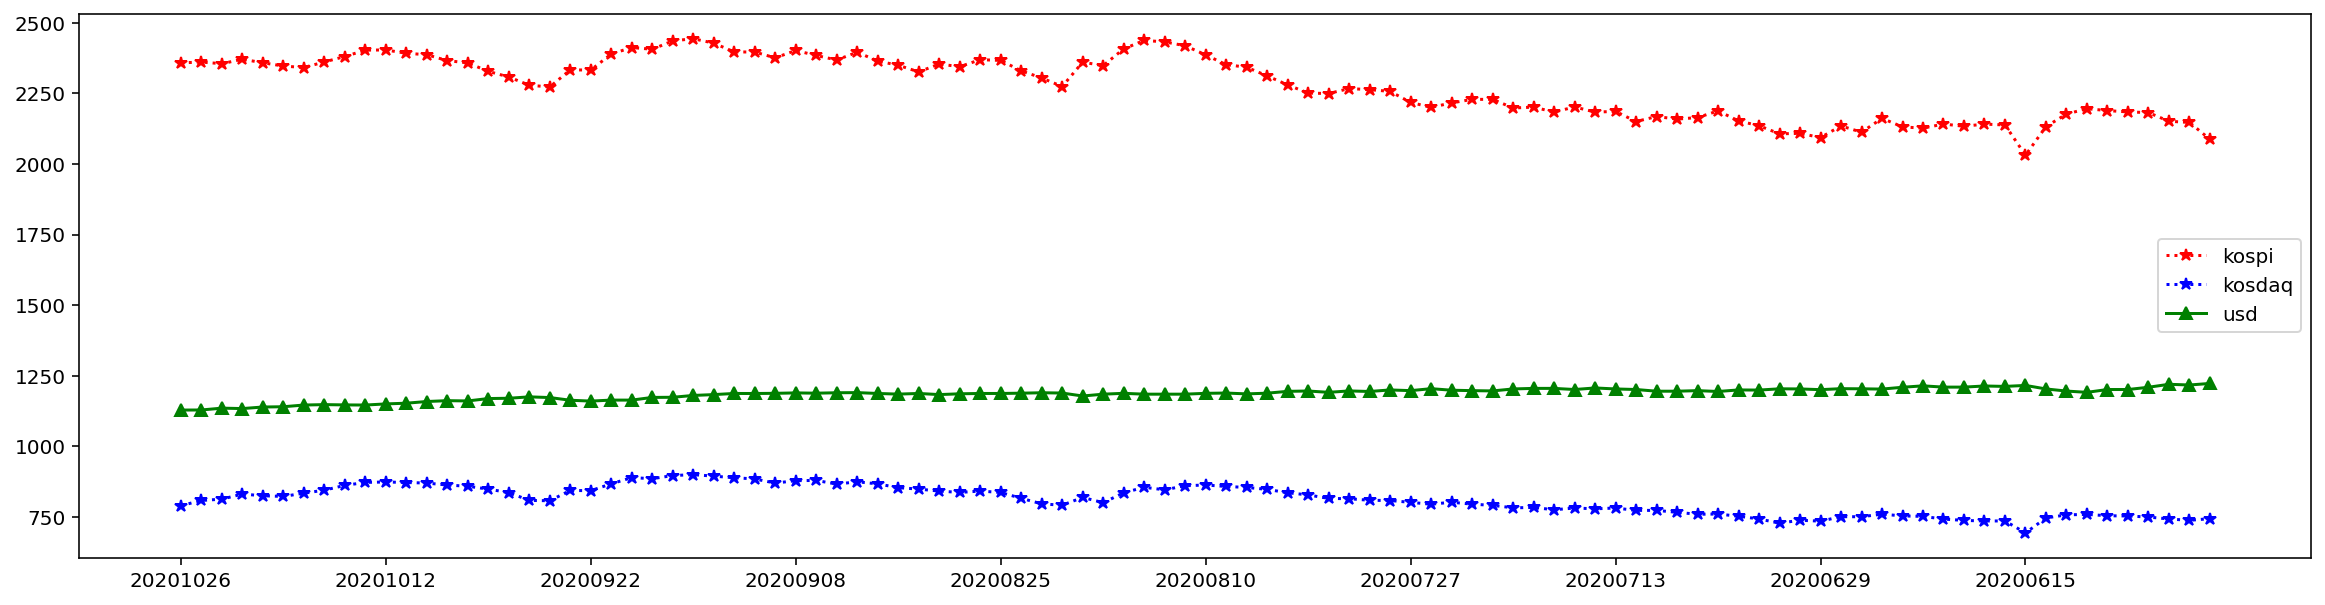

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(merge_df["dt"], merge_df["ncv_kospi"], "r*:", label="kospi")
plt.plot(merge_df["dt"], merge_df["ncv_kosdaq"], "b*:", label="kosdaq")
plt.plot(merge_df["dt"], merge_df["nv"], "g^-", label="usd")

# 라벨 데이터 
plt.legend(loc=0)
#xtick이 항상 10개 출력되도록
step = len(merge_df) // 10
plt.xticks(merge_df[::step]["dt"])

plt.show()

### 4. 정규화: Nomalization
- z = (x - min(x)) / (max(x) - min(x)) 
    - 결과는 0 ~ 1의 데이터를 갖습니다.
    - 이유: 최대값과 최소값의 격차를 분모로, 현재 값과 최소값의 격차를 분자로
        - 최대값과 최소값의 격차 > 현재 값과 최소값의 격차

In [27]:
from sklearn import preprocessing

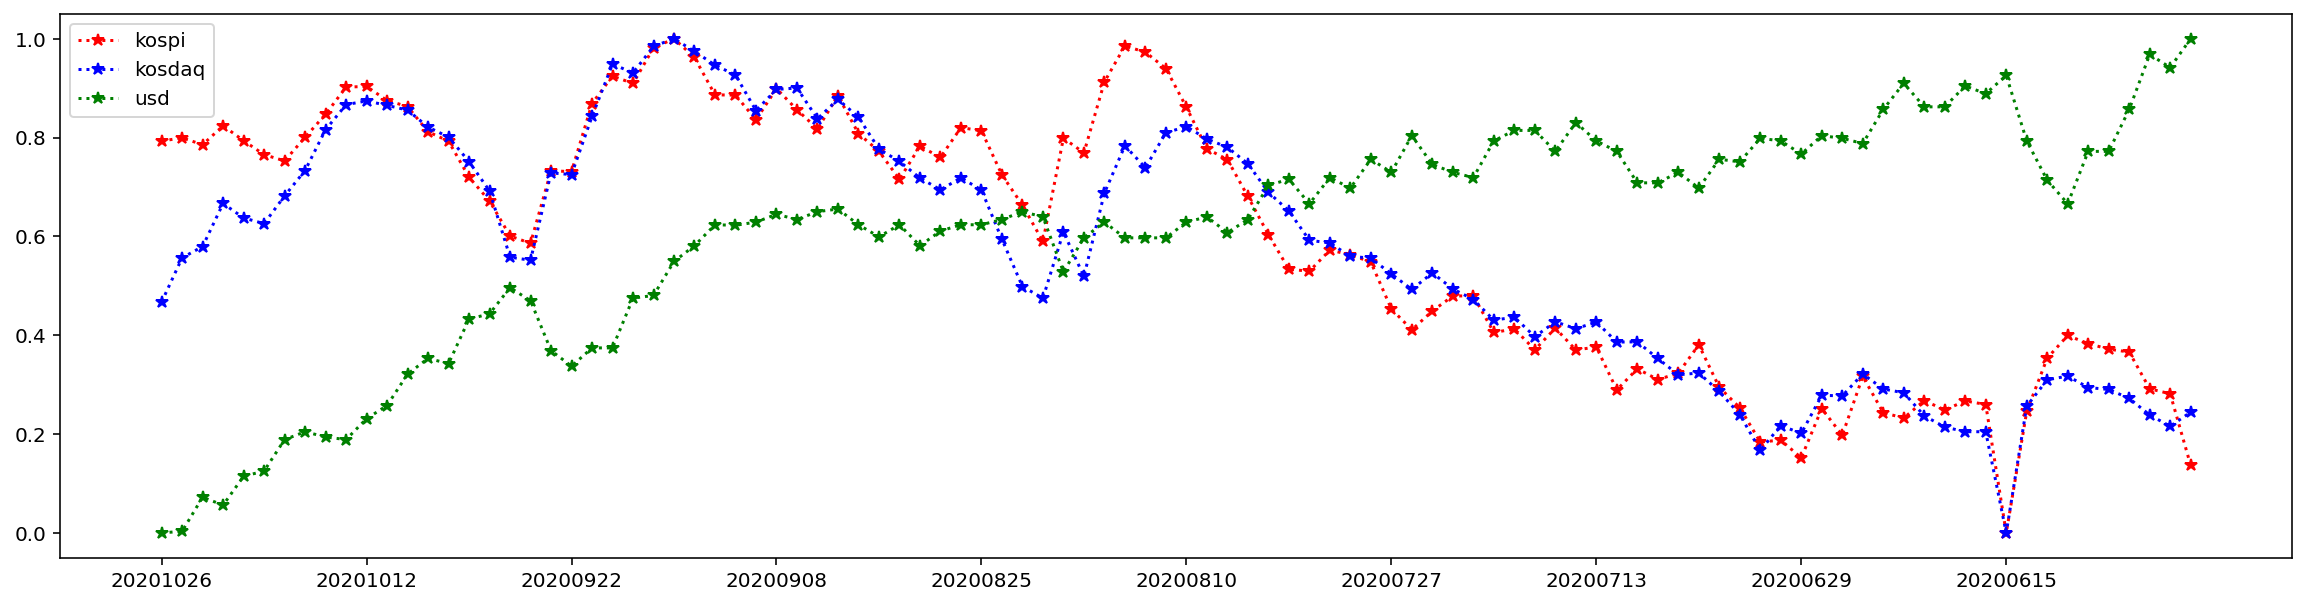

In [33]:
plt.figure(figsize=(20,5))
plt.plot(merge_df["dt"], preprocessing.minmax_scale(merge_df["ncv_kospi"]), "r*:", label="kospi")
plt.plot(merge_df["dt"], preprocessing.minmax_scale(merge_df["ncv_kosdaq"]), "b*:", label="kosdaq")
plt.plot(merge_df["dt"], preprocessing.minmax_scale(merge_df["nv"]), "g*:", label="usd")

# 라벨 데이터 
plt.legend(loc=0)
#xtick이 항상 10개 출력되도록
step = len(merge_df) // 10
plt.xticks(merge_df[::step]["dt"])

plt.show()

In [35]:
# 상관계수

In [ ]:
np.co